# Predicting. Best model is Random Forest Regressor, compared to RF classifier and decision tree

In [2]:
import os
import math 
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

Load cleaned and pre-processed data from previous captone steps

In [3]:
with open('preprocessed_datamaster_list.pkl', "rb") as file:
    loaded_data = pickle.load(file)

In [34]:
loaded_data.keys()

dict_keys(['df', 'X_train', 'X_test', 'y_train', 'y_test', 'scaler', 'X_train_scaled', 'X_test_scaled'])

In [5]:
df = loaded_data['df']

Inspect our df

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   article_number                 2072 non-null   float64
 1   citation_number                2072 non-null   float64
 2   impact_factor                  2072 non-null   float64
 3   year                           2072 non-null   float64
 4   cited_by                       2072 non-null   float64
 5   specifier_in_journal_False     2072 non-null   uint8  
 6   specifier_in_journal_True      2072 non-null   uint8  
 7   topic_in_most_cited_False      2072 non-null   uint8  
 8   topic_in_most_cited_True       2072 non-null   uint8  
 9   specifier_in_most_cited_False  2072 non-null   uint8  
 10  specifier_in_most_cited_True   2072 non-null   uint8  
dtypes: float64(5), uint8(6)
memory usage: 93.2 KB


# First model: Decision Tree
Use decision tree to see the difference. Problem of this method is the values we have a numeric.
We want to first apply some rules to seperate them into category.
For example, impact factor (IF) <1 , 1 to 2, 2 to 5, greater than 5.
But the arbitrary values may bring in bias, hence we want to adpot the quantile method for citation number, impact factor, cited time, article number.
And year seperated by each five years.


In [7]:
df['year'].max()

2022.0

In [8]:
# Define the number of bins for each feature
num_bins = 5

# Define the bin edges for year feature
min_year = int(df['year'].min())
max_year = int(df['year'].max())
bin_width = 5
bin_edges = list(range(min_year, max_year + bin_width, bin_width))
bin_labels_yr = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]

percentiles = [0, 50, 80, 90, 95, 99, 100]
bin_edges_IF = np.percentile(df['impact_factor'], percentiles) 
bin_labels_IF = [f"{int(bin_edges_IF[i])}-{float(int(bin_edges_IF[i+1])-0.01)}" for i in range(len(bin_edges_IF)-1)]

# Compute the quantile values for the 'citation_number' feature
quantile_values_cn = np.linspace(0, 1, num_bins + 1)
citation_number_quantiles = df['citation_number'].quantile(quantile_values_cn[1:]).astype('int')

# Compute the quantile values for the 'article_number' feature
quantile_values_article = np.linspace(0, 1, num_bins + 1)
article_number_quantiles = df['article_number'].quantile(quantile_values_article[1:]).astype('int')

# Compute the quantile values for the 'cited_by' feature
quantile_values_cited_by = np.linspace(0, 1, num_bins + 1)
cited_by_quantiles = df['cited_by'].quantile(quantile_values_cited_by[1:]).astype('int')


# Create a copy of the original DataFrame
quantile_df = df.copy()

# Apply quantile-based binning to the numerical features
quantile_df['citation_number_bins'] = pd.qcut(df['citation_number'], q=quantile_values_cn, labels=citation_number_quantiles)
quantile_df['article_number_bins'] = pd.qcut(df['article_number'], q=quantile_values_article, labels=article_number_quantiles)
quantile_df['cited_by_bins'] = pd.qcut(df['cited_by'], q=quantile_values_cited_by, labels=cited_by_quantiles)

quantile_df['year_bins'] = pd.cut(df['year'], bins=bin_edges, labels=bin_labels_yr, include_lowest=True)
quantile_df['impact_factor_bins'] = pd.cut(df['impact_factor'], bins=bin_edges_IF, labels=bin_labels_IF, include_lowest=True)

# Convert the binned features to categorical data type
quantile_df['citation_number_bins'] = quantile_df['citation_number_bins'].astype('category')
quantile_df['article_number_bins'] = quantile_df['article_number_bins'].astype('category')
quantile_df['cited_by_bins'] = quantile_df['cited_by_bins'].astype('category')

quantile_df['year_bins'] = quantile_df['year_bins'].astype('category')
quantile_df['impact_factor_bins'] = quantile_df['impact_factor_bins'].astype('category')

# Drop the original numerical features
quantile_df.drop(['citation_number', 'article_number', 'year', 'cited_by', 'impact_factor'], axis=1, inplace=True)

# Inspect quantile_df
quantile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   specifier_in_journal_False     2072 non-null   uint8   
 1   specifier_in_journal_True      2072 non-null   uint8   
 2   topic_in_most_cited_False      2072 non-null   uint8   
 3   topic_in_most_cited_True       2072 non-null   uint8   
 4   specifier_in_most_cited_False  2072 non-null   uint8   
 5   specifier_in_most_cited_True   2072 non-null   uint8   
 6   citation_number_bins           2072 non-null   category
 7   article_number_bins            2072 non-null   category
 8   cited_by_bins                  2072 non-null   category
 9   year_bins                      2072 non-null   category
 10  impact_factor_bins             2072 non-null   category
dtypes: category(5), uint8(6)
memory usage: 23.6 KB


* Let's see how many are in each category

In [9]:
# Iterate over the columns in the DataFrame
for column in quantile_df.select_dtypes(include='category'):
    categories = quantile_df[column].cat.categories
    print(f"Categories of '{column}': {categories}")

Categories of 'citation_number_bins': Int64Index([62, 687, 6500, 48200, 3400000], dtype='int64', name='citation_number')
Categories of 'article_number_bins': Int64Index([66, 233, 822, 2500, 53900], dtype='int64', name='article_number')
Categories of 'cited_by_bins': Int64Index([13, 71, 226, 667, 40300], dtype='int64', name='cited_by')
Categories of 'year_bins': Index(['1966-1970', '1971-1975', '1976-1980', '1981-1985', '1986-1990',
       '1991-1995', '1996-2000', '2001-2005', '2006-2010', '2011-2015',
       '2016-2020', '2021-2025'],
      dtype='object')
Categories of 'impact_factor_bins': Index(['0-0.99', '1-3.99', '4-6.99', '7-9.99', '10-27.99', '28-213.99'], dtype='object')


In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [50]:
# Separate the features and the target variable
X_tree = quantile_df.drop('impact_factor_bins', axis=1)
y_tree = quantile_df['impact_factor_bins']

# Split the data into training and testing sets
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.2, random_state=42)

# Apply one-hot encoding to categorical variables
encoder = OneHotEncoder(sparse=False)
X_train_tree_encoded = encoder.fit_transform(X_train_tree)
X_test_tree_encoded = encoder.transform(X_test_tree)

# Reshape and encode the target variable
y_train_reshaped_tree = y_train_tree.values.reshape(-1, 1)
y_test_reshaped_tree = y_test_tree.values.reshape(-1, 1)
y_train_encoded_tree = encoder.fit_transform(y_train_reshaped_tree)
y_test_encoded_tree = encoder.transform(y_test_reshaped_tree)

# Create the decision tree regressor
tree_regressor = DecisionTreeRegressor(random_state=42)

# Fit the model to the training data
tree_regressor.fit(X_train_tree_encoded, y_train_encoded_tree)

# Predict on the testing data
y_pred_encoded_tree = tree_regressor.predict(X_test_tree_encoded)

# Calculate the mean squared error
mse_tree = mean_squared_error(y_test_encoded_tree, y_pred_encoded_tree)
print(f"Tree Mean Squared Error: {mse_tree:.2f}")

Tree Mean Squared Error: 0.05


Accuracy: 0.78


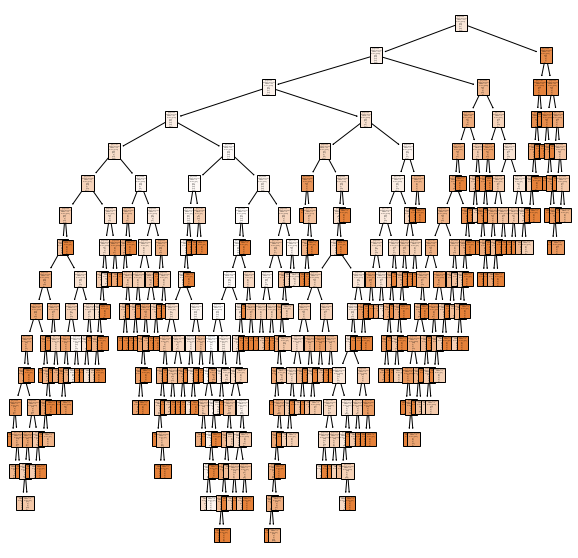

In [27]:
from sklearn.metrics import accuracy_score
from sklearn import tree
# Calculate the accuracy
y_pred_tree = encoder.inverse_transform(y_pred_encoded_tree)
y_test_tree_decoded = encoder.inverse_transform(y_test_encoded_tree)

accuracy = accuracy_score(y_test_tree_decoded, y_pred_tree)
print(f"Accuracy: {accuracy:.2f}")

# Get the feature names from the original X_tree dataframe
feature_names = X_tree.columns

# Display the decision tree without feature names
plt.figure(figsize=(10, 10))
tree.plot_tree(tree_regressor, filled=True)
plt.show()

In [53]:
feature_names = X_tree.columns.to_list()
feature_names

['specifier_in_journal_False',
 'specifier_in_journal_True',
 'topic_in_most_cited_False',
 'topic_in_most_cited_True',
 'specifier_in_most_cited_False',
 'specifier_in_most_cited_True',
 'citation_number_bins',
 'article_number_bins',
 'cited_by_bins',
 'year_bins']

In [55]:
def find_shortest_path(tree, encoder, target_levels):
    # Initialize the current node as the root of the tree
    current_node = 0
    path_to_target = []
    
    # Traverse the tree until a leaf node is reached
    while tree.children_left[current_node] != tree.children_right[current_node]:
        # Get the feature index and threshold for the current node
        feature_index = tree.feature[current_node]
        threshold = tree.threshold[current_node]
        
        if feature_index != -2:  # Exclude invalid feature index
            # Get the feature names from the encoder
            feature_names = encoder.get_feature_names_out(input_features=[str(feature_index)])
            # Append the feature name and threshold to the current path
            path_to_target.append((feature_names[0], threshold))
        
        # Determine the next node based on the comparison with the threshold
        if all(level <= str(threshold) for level in target_levels):
            current_node = tree.children_left[current_node]
        else:
            current_node = tree.children_right[current_node]
    
    return path_to_target

# Find the shortest path to the target levels
target_levels = ['28-213.99']
path_to_target = find_shortest_path(tree_regressor.tree_, encoder, target_levels)

# Print the shortest path
print("Shortest path to reach '28-213.99':")
for feature_name, threshold in path_to_target:
    print(f"- {feature_name} <= {threshold}")


Shortest path to reach '28-213.99':
- 12_0-0.99 <= 0.5
- 37_0-0.99 <= 0.5
- 23_0-0.99 <= 0.5
- 0_0-0.99 <= 0.5
- 11_0-0.99 <= 0.5
- 17_0-0.99 <= 0.5


The result shows this approach is less idea, let's use random forest.

# Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#### This will be the visualization tool we gonna use

In [137]:
from scipy.interpolate import make_interp_spline
def view_rf_results(list_of_n , list_of_accuracy):
    for i, ac in enumerate(list_of_accuracy):
        print(f'n_estimator: {list_of_n[i]} has accuracy of {ac}')

    # Generate a smooth line plot
    x_smooth = np.linspace(min(list_of_n), max(list_of_n), 200)
    y_smooth = make_interp_spline(list_of_n, list_of_accuracy)(x_smooth)

    # Plot the line
    plt.figure(figsize=(8, 6))
    plt.plot(list_of_n, list_of_accuracy, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Estimators')
    plt.grid(True)
    plt.show()

In [138]:
# Initialize the random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_tree_encoded, y_train_encoded_tree)

# Make predictions on the test set
predictions_rf = rf.predict(X_test_tree_encoded)

# Evaluate the model's accuracy
accuracy_rf = accuracy_score(y_test_encoded_tree, predictions_rf)
print('Accuracy:', accuracy_rf)

Accuracy: 0.7590361445783133


#### Not much better, now lt's visualize it

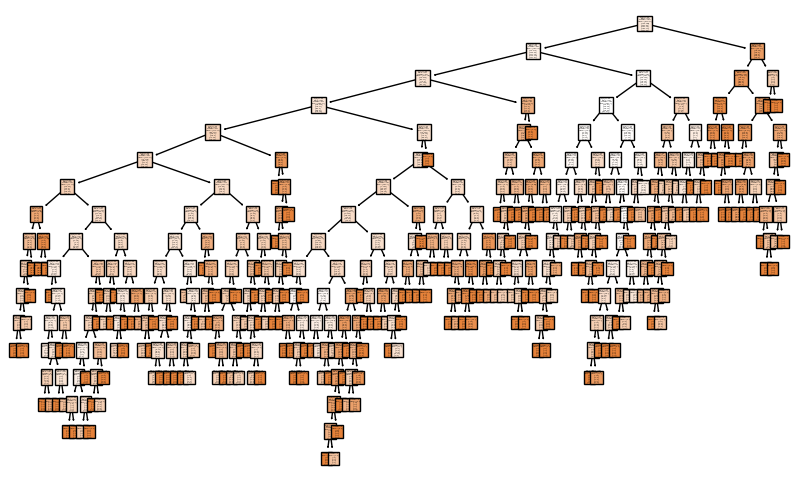

In [139]:
# Visualize the first decision tree in the random forest
plt.figure(figsize=(10, 6))
plot_tree(rf.estimators_[0], filled=True)
plt.show()

Let's explore other ns

n_estimator: 5 has accuracy of 0.7614457831325301
n_estimator: 10 has accuracy of 0.763855421686747
n_estimator: 20 has accuracy of 0.7542168674698795
n_estimator: 30 has accuracy of 0.7566265060240964
n_estimator: 50 has accuracy of 0.7710843373493976
n_estimator: 75 has accuracy of 0.7710843373493976
n_estimator: 100 has accuracy of 0.7590361445783133
n_estimator: 150 has accuracy of 0.7614457831325301
n_estimator: 200 has accuracy of 0.7614457831325301
n_estimator: 250 has accuracy of 0.763855421686747
n_estimator: 300 has accuracy of 0.763855421686747
n_estimator: 400 has accuracy of 0.7614457831325301
n_estimator: 500 has accuracy of 0.7614457831325301
n_estimator: 750 has accuracy of 0.7710843373493976
n_estimator: 800 has accuracy of 0.7710843373493976
n_estimator: 950 has accuracy of 0.7710843373493976
n_estimator: 1000 has accuracy of 0.7710843373493976


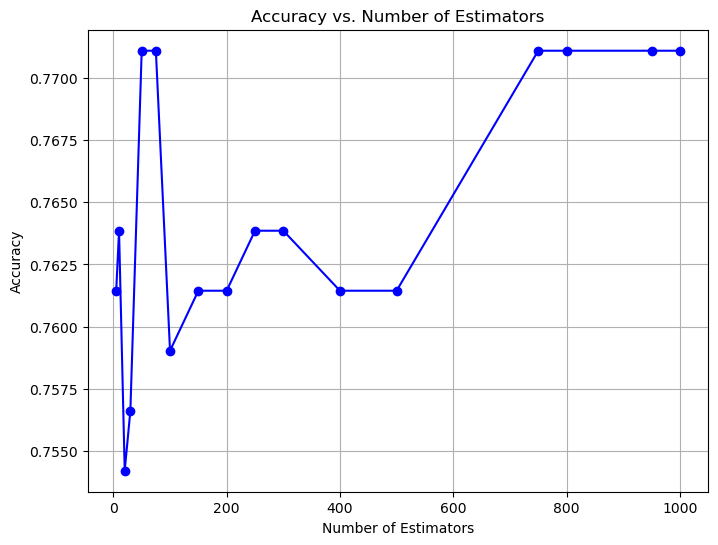

In [140]:
list_of_n = [5, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 400, 500, 750, 800, 950, 1000]
list_of_accuracy = []

for n in list_of_n:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)

    # Train the model
    rf.fit(X_train_tree_encoded, y_train_encoded_tree)

    # Make predictions on the test set
    predictions_rf = rf.predict(X_test_tree_encoded)

    # Evaluate the model's accuracy
    accuracy_rf = accuracy_score(y_test_encoded_tree, predictions_rf)
    list_of_accuracy.append(accuracy_rf)
view_rf_results(list_of_n , list_of_accuracy)

#### Seems like accuracy has potential to be higher around 50 and 75, and platto after 750. Exclude the higher values to make it more sensible

n_estimator: 50 has accuracy of 0.7710843373493976
n_estimator: 55 has accuracy of 0.7686746987951807
n_estimator: 60 has accuracy of 0.7710843373493976
n_estimator: 61 has accuracy of 0.7734939759036145
n_estimator: 62 has accuracy of 0.7734939759036145
n_estimator: 63 has accuracy of 0.7734939759036145
n_estimator: 64 has accuracy of 0.7734939759036145
n_estimator: 65 has accuracy of 0.7734939759036145
n_estimator: 66 has accuracy of 0.7734939759036145
n_estimator: 67 has accuracy of 0.7734939759036145
n_estimator: 68 has accuracy of 0.7734939759036145
n_estimator: 69 has accuracy of 0.7734939759036145
n_estimator: 70 has accuracy of 0.7734939759036145
n_estimator: 72 has accuracy of 0.7734939759036145
n_estimator: 75 has accuracy of 0.7710843373493976


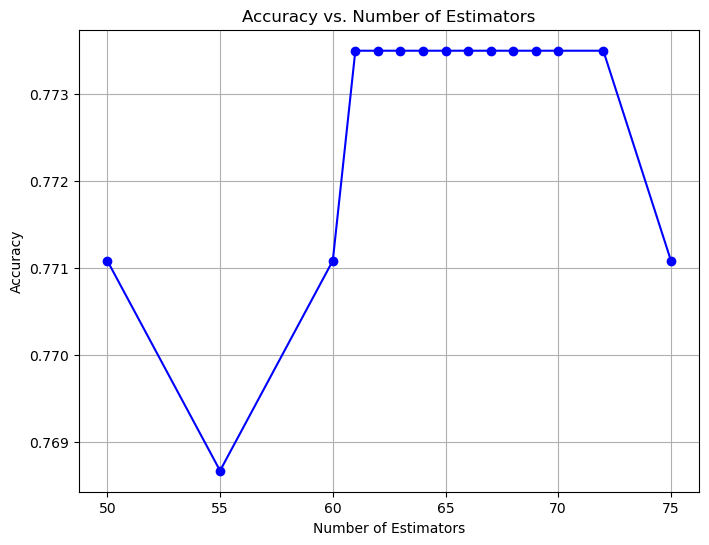

In [141]:
list_of_n = [50, 55, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 75]
list_of_accuracy = []

for n in list_of_n:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)

    # Train the model
    rf.fit(X_train_tree_encoded, y_train_encoded_tree)

    # Make predictions on the test set
    predictions_rf = rf.predict(X_test_tree_encoded)

    # Evaluate the model's accuracy
    accuracy_rf = accuracy_score(y_test_encoded_tree, predictions_rf)
    list_of_accuracy.append(accuracy_rf)
view_rf_results(list_of_n , list_of_accuracy)

Based on the data provided, let's take a beginner-friendly approach to understand the relationship between the number of estimators (n_estimators) and the accuracy of a model. Here's what we can conclude:

We tested different values for n_estimators and measured the accuracy of the model. The accuracy tells us how well the model performs in making correct predictions. The values we tested are: 50, 55, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, and 75.

Here's what we found:

When we used 50 estimators, the accuracy was 0.771, which means the model made correct predictions about 77.1% of the time.
With 55 estimators, the accuracy was 0.769, which means the model's predictions were correct about 76.9% of the time.
When we increased the number of estimators to 60, the accuracy remained similar at 0.771, which is around 77.1% accuracy.
The accuracy improved slightly when we used 61 estimators, reaching 0.773 or approximately 77.3% accuracy.
For values of n_estimators from 62 to 70, the accuracy remained stable at 0.773, meaning the model's predictions were correct about 77.3% of the time consistently.
When we further increased the number of estimators to 72, the accuracy stayed the same at 0.773.
Finally, at 75 estimators, the accuracy dropped slightly to 0.771 or around 77.1% accuracy.
Based on these results, we can conclude that increasing the number of estimators beyond 61 doesn't seem to significantly improve the accuracy of the model for this particular dataset. So, choosing 61 as the number of estimators could be a good balance between accuracy and computational efficiency for beginners.

Please note that these conclusions are specific to the dataset provided, and it's essential to consider different factors and perform thorough experimentation when selecting the optimal number of estimators for your specific problem.

# Random Forest Regressor
### Since the classifier did a good job, we want to know if we can predict the value
### Note that even if this turned out to have a great accuracy, the nature of research breakthrough and field response does not always follow certain path.
### This can only help us to predict general trend, and let us know what plays a significant part in selecting a high IF journal

Since we've done scaling in feature engineering capstone, we will use that dataset to predict the value.

In [62]:
X_train = loaded_data['X_train']
X_test = loaded_data['X_test']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']
scaler = loaded_data['scaler']
X_train_scaled = loaded_data['X_train_scaled']
X_test_scaled = loaded_data['X_test_scaled']

In [63]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor()

# Train the model
model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [64]:
# Make predictions on the testing set
predictions = model.predict(X_test_scaled)

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 0.16601919036144552
Mean Absolute Error: 0.168274698795181
R-squared: 0.9987042113870006


## We now want to inspect the weight of each feature

In [68]:
# Retrieve feature importances
feature_importances = model.feature_importances_

# Create a dataframe to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the dataframe by importance values in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                         Feature  Importance
3                       cited_by    0.877822
1                citation_number    0.076995
0                 article_number    0.037466
2                           year    0.006387
4     specifier_in_journal_False    0.000377
5      specifier_in_journal_True    0.000371
6      topic_in_most_cited_False    0.000187
7       topic_in_most_cited_True    0.000156
9   specifier_in_most_cited_True    0.000123
8  specifier_in_most_cited_False    0.000117


**cited_by**: The number of times the journal's most cited article has been referenced is the most important factor in predicting the impact factor.

**citation_number**: The total number of citations received by the journal also plays a significant role in determining the impact factor.

**article_number**: The unique identifier of each article has a moderate influence on the impact factor.

**year**: The year of publication has a minor impact on the impact factor.

The other features, such as specifier_in_journal, topic_in_most_cited, and specifier_in_most_cited, have very little influence on the impact factor prediction. They don't significantly affect the calculated impact factor.

In simple terms, the number of citations for the most cited article and the overall number of citations received by the journal are the most important factors in estimating the impact factor. Other factors, like the article identifier and publication year, have a lesser impact. The presence or absence of specifiers or topics in the journal or most cited articles does not strongly affect the impact factor prediction.

### Line plot of percentage error

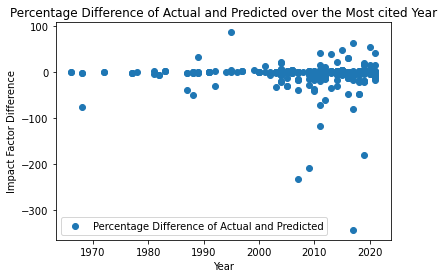

In [70]:
sorted_indices = X_test['year'].argsort()
sorted_years = X_test['year'].iloc[sorted_indices]
sorted_actual = y_test.iloc[sorted_indices]
sorted_predicted = predictions[sorted_indices]
percentage_difference = (sorted_actual - sorted_predicted)/sorted_actual * 100

plt.scatter(sorted_years, percentage_difference, label='Percentage Difference of Actual and Predicted')
plt.xlabel('Year')
plt.ylabel('Impact Factor Difference')
plt.title('Percentage Difference of Actual and Predicted over the Most cited Year')
plt.legend()
plt.show()

## Let's see more details

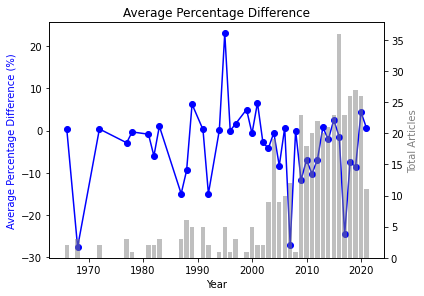

In [73]:
unique_years = sorted_years.unique()
average_percentage_difference = []
total_articles = []

for year in unique_years:
    indices = np.where(sorted_years == year)[0]
    year_actual = sorted_actual.iloc[indices]
    year_predicted = sorted_predicted[indices]
    year_percentage_difference = (year_actual - year_predicted) / year_actual * 100
    year_percentage_difference = year_percentage_difference.replace([-np.inf, np.inf], np.nan)  # Replace -inf and inf with NaN
    year_percentage_difference = year_percentage_difference.dropna()  # Drop rows with NaN values
    year_average = np.mean(year_percentage_difference)
    year_average = round(year_average, 2)  # Round to 2 decimal places
    average_percentage_difference.append(year_average)
    total_articles.append(len(indices))

year_difference_df = pd.DataFrame({'Year': unique_years, 'Total Articles': total_articles, 'Average Percentage Difference': average_percentage_difference})
year_difference_df['Average Percentage Difference'] = year_difference_df['Average Percentage Difference'].apply(lambda x: '{:.2f}'.format(x))  # Format to 2 decimal places

fig, ax1 = plt.subplots()

# Plotting average percentage difference as a line
ax1.plot(unique_years, average_percentage_difference, color='blue', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Percentage Difference (%)', color='blue')

# Creating a twin axis for total articles as columns
ax2 = ax1.twinx()
ax2.bar(unique_years, total_articles, color='gray', alpha=0.5)
ax2.set_ylabel('Total Articles', color='gray')

# Adjusting the layout
plt.tight_layout()
ax1.set_title("Average Percentage Difference")
# Display the plot
plt.show()

In [182]:
print(year_difference_df)

      Year  Total Articles Average Percentage Difference
0   1966.0               2                          0.50
1   1968.0               3                        -30.67
2   1972.0               2                          0.00
3   1977.0               3                          0.27
4   1978.0               1                          0.00
5   1981.0               2                         -0.71
6   1982.0               2                        -10.22
7   1983.0               3                         -0.23
8   1987.0               3                        -10.62
9   1988.0               6                         -8.56
10  1989.0               5                          6.95
11  1991.0               5                          0.30
12  1992.0               2                        -21.52
13  1994.0               1                          0.34
14  1995.0               5                         21.87
15  1996.0               1                         -0.00
16  1997.0               3     

#### Although it's not suprising that a journal with more over citation has a higher value of IF, but what is important to note is the most cited article seems to play a great role in boosting the journal's IF. Hence a good paper does make a journal famous, but not the way around. Also note that in recent years the impact facotor percentage differences is more noisy than before, and it will be interesting to see why most cited articles from certain years (like 2017, 2007, and 1995) deviates from the pattern.
### SO, journals, you should give us money rather than asking us for money when publishing with you :D.

### Scatter Plot:

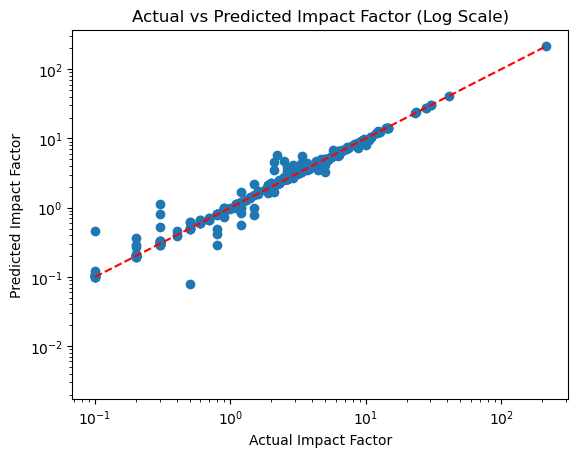

In [171]:
plt.scatter(y_test, predictions)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Impact Factor')
plt.ylabel('Predicted Impact Factor')
plt.title('Actual vs Predicted Impact Factor (Log Scale)')

# Add diagonal line
max_value = max(max(y_test), max(predictions))
plt.plot([0.1, max_value], [0.1, max_value], color='red', linestyle='--')
plt.show()

### Histogram

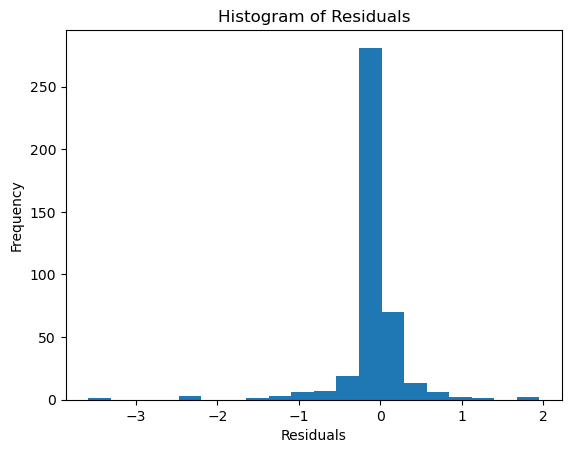

In [172]:
residuals = y_test - predictions

plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()